**For 4701 Artificial Intelligence at Columbia University 2022**

Blackjack as a Markov Decision Process, Solve for the optimal policy

*   There are 22 numbered states in the state space
*   Each represents a possible card sum from 0 to 21
*   We are drawing WITH replacement
*   Thus the probability of a 1-9 value is 1/13
*   The probability of a 10 value card is 4/13
*   There is a constant living reward with every draw action



**Value Iteration**

Compute the optimal values for each of the 22 non-terminal states
Returns the converged values list V*

In [6]:
from typing import Tuple
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

def value_iteration(
    V0: npt.NDArray, 
    lr: float, 
    gamma:float, 
    epsilon: float=1e-12
    ) -> npt.NDArray:

  Vi = np.zeros_like(V0)
  Vi[21]

  while True:
    max_diff = -np.inf
    for state in range(12):  ##For states 0-11
      successors = [] #Generate list of successors for current state
      for successor in range(1,10):
        successors.append((1/13)*(lr + (gamma*V0[state + successor])))
      successors.append((4/13)*(lr + (gamma*V0[state + 10])))
      Vi[state] = max(sum(successors), state)
      diff = np.abs(Vi[state] - V0[state])
      if diff > max_diff:
        max_diff = diff

    ## for state 12
    state = 12
    successors = []
    for successor in range(1,10):
      successors.append((1/13)*(lr + (gamma*V0[state + successor])))
    successors.append((4/13)*(lr + 0)) #bust
    Vi[state] = max(sum(successors), state)
    diff = np.abs(Vi[state] - V0[state])
    if diff > max_diff:
      max_diff = diff

    ## for states 13-21
    for state in range(13,21):
      successors = []
      for successor in range(1, 22 - state):
        successors.append((1/13)*(lr + (gamma*V0[state + successor])))
      successors.append(((13-successor)/13)*(lr + 0)) #bust
      Vi[state] = max(sum(successors), state)
      diff = np.abs(Vi[state] - V0[state])
      if diff > max_diff:
        max_diff = diff
        
    ## for state 21
    Vi[21] = (lr + 21)
    if max_diff < epsilon:
      return Vi
    else:
      V0 = Vi
  return V0

**Using the values computed above, we extract the policy 0 or 1 for each state**

In [2]:
def value_to_policy(V: npt.NDArray, lr: float, gamma: float) -> npt.NDArray:
  policy = np.zeros(V.size)
  p19 = 1/13
  p10 = 4/13
  for state in range(12):
    successors = [] #Generate list of successors for current state
    for successor in range(1,10):
      successors.append(p19*(lr + (gamma*V[state + successor])))
    successors.append(p10*(lr + (gamma*V[state + 10])))
    if sum(successors) > state:
      policy[state] = 1

  ## for state 12
  state = 12
  successors = []
  for successor in range(1,10):
    successors.append((1/13)*(lr + (gamma*V[state + successor])))
  successors.append((4/13)*(lr + 0)) #bust
  if sum(successors) > state:
      policy[state] = 1

  ## for states 13-21
  for state in range(13,22):
    successors = []
    for successor in range(1, 22 - state):
      successors.append((1/13)*(lr + (gamma*V[state + successor])))
    successors.append(((13-successor)/13)*(lr + 0)) #bust
    if sum(successors) > state:
      policy[state] = 1

  return policy

**Temporal Difference Learning**

Q learning algorithm:

*   Keep track of Q values (22x2 np array)
*   Q[s,a] = Q(s,a) where a = 0 is stop & a = 1 is the draw action
*   Epsilon-greedy method of action selection (exploration vs exploitation)
*   If stopping, reward r = s
*   If drawing, r = lr
*   draw() will compute successor state s'
*   Update current Q value as well as record with current state, action, & reward
*   Q value of "done" state is 0
*   Reset s to 0 if we stop or s'> 21, else s = s'



In [3]:
def draw() -> int:
  probs = 1/13*np.ones(10)
  probs[-1] *= 4
  return np.random.choice(np.arange(1,11), p=probs)

def Qlearn(
    Q0: npt.NDArray, 
    lr: float, 
    gamma: float, 
    alpha: float, 
    epsilon: float, 
    N: int
    ) -> Tuple[npt.NDArray, npt.NDArray]:
  
  record = np.zeros((N,3))
  state = 0
  for transition in range(N):
    #generate sequence
    rando = np.random.random()
    if rando < epsilon:
      # explore
      rando2 = np.random.random()
      if rando2 < 0.5: #DRAW
        action = 1
        successor = draw() + state
        reward = lr 
        if successor > 21:
          successor = 0
      else: #STOP
        action = 0
        reward = state
        successor = 0
    else:
      # exploit
      successor = draw() + state
      if successor > 21:
        successor = 0
      stop = state
      if successor > stop:
        action = 1
        reward = lr 
      else:
        action = 0
        reward = stop
        successor = 0

    # UPDATES    
    record[transition][0] = state
    record[transition][1] = action
    record[transition][2] = reward

    if successor == 0:
      Q0[state][action] = Q0[state][action] + (alpha * (reward - Q0[state][action]))
    else:
      Q0[state][action] = Q0[state][action] + (alpha * (reward + (gamma * max(Q0[successor])) - Q0[state][action]))
    
    state = successor

  return Q0, record

**RL Analysis**

Verify Qlearn by comparing learned state values(max of each row in Q) with those returned by value iteration. 

In [4]:
def RL_analysis():
  lr, gamma, alpha, epsilon, N = 0, 1, 0.1, 0.1, 10000
  visits = np.zeros((22,6))
  rewards = np.zeros((N,6))
  values = np.zeros((22,6))

  for i in range(6):
    _, record = Qlearn(np.zeros((22,2)), lr, gamma, alpha, epsilon, 10000*i)
    vals, counts = np.unique(record[:,0], return_counts=True)
    visits[vals.astype(int),i] = counts
    _, record = Qlearn(np.zeros((22,2)), lr, gamma, alpha, 0.2*i, N)
    rewards[:,i] = record[:,2]
    vals, _ = Qlearn(np.zeros((22,2)), lr, gamma, min(0.2*i+0.1,1), epsilon, N)
    values[:,i] = np.max(vals, axis=1)

  plt.figure()
  plt.plot(visits)
  plt.legend(['N=0', 'N=10k', 'N=20k', 'N=30k' ,'N=40k', 'N=50k'])
  plt.title('Number of visits to each state')

  plt.figure()
  plt.plot(np.cumsum(rewards, axis=0))
  plt.legend(['e=0.0', 'e=0.2', 'e=0.4' ,'e=0.6', 'e=0.8', 'e=1.0'])
  plt.title('Cumulative rewards received')

  plt.figure()
  plt.plot(values)
  plt.legend(['a=0.1' ,'a=0.3', 'a=0.5', 'a=0.7', 'a=0.9', 'a=1.0'])
  plt.title('Estimated state values');

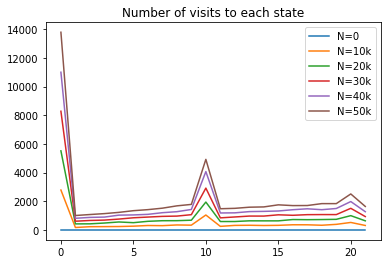

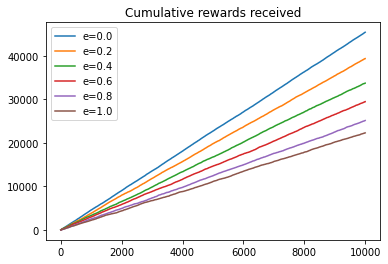

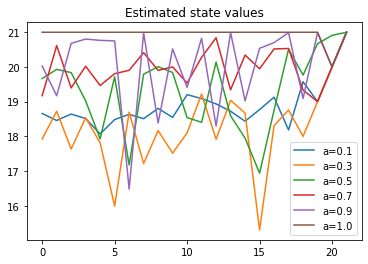

In [5]:
RL_analysis()

In [7]:
Q = np.zeros((22,2))
values, record = Qlearn(Q, 0, 1, 0.1, 0.1, 50000)
print(values)
print(record[:20,:])

[[ 0.         18.25363053]
 [ 0.99484622 18.62102279]
 [ 1.9907232  18.23414925]
 [ 2.99400997 18.26987332]
 [ 3.99575553 18.26382156]
 [ 4.99771612 18.18726788]
 [ 5.99778007 17.68313949]
 [ 6.99918726 18.20610084]
 [ 7.99784223 18.49503489]
 [ 8.99915359 18.58980011]
 [10.         18.9557972 ]
 [10.99149091 19.0628259 ]
 [12.         17.71631706]
 [13.         18.1852872 ]
 [14.         18.64580922]
 [15.         17.77640854]
 [16.         17.21326018]
 [17.         19.40437842]
 [18.         18.63790157]
 [19.         17.79201848]
 [20.         13.91656105]
 [21.          0.        ]]
[[ 0.  1.  0.]
 [10.  1.  0.]
 [20.  0. 20.]
 [ 0.  1.  0.]
 [ 4.  1.  0.]
 [ 6.  1.  0.]
 [10.  1.  0.]
 [19.  0. 19.]
 [ 0.  1.  0.]
 [ 6.  1.  0.]
 [15.  1.  0.]
 [17.  0. 17.]
 [ 0.  1.  0.]
 [ 7.  1.  0.]
 [17.  0. 17.]
 [ 0.  1.  0.]
 [ 4.  1.  0.]
 [14.  1.  0.]
 [ 0.  1.  0.]
 [10.  1.  0.]]


In [8]:
V = np.zeros(22)
gamma = 1
living_reward = 0
Vstar = value_iteration(V, living_reward , gamma)
policy = value_to_policy(Vstar, living_reward, gamma)
#print(policy)
print(Vstar)
#plot = plt.plot(policy)
#plt.title('Pi*')
#plt.xticks(range(22))
#plt.show(plot)

[ 6.53846154  7.53846154  8.53846154  9.53846154 10.53846154 11.53846154
 12.53846154 13.53846154 14.53846154 15.53846154 16.53846154 17.53846154
 12.         13.         14.         15.         16.         17.
 18.         19.         20.         21.        ]


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


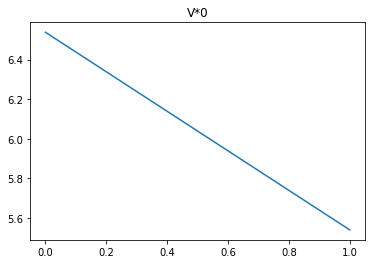

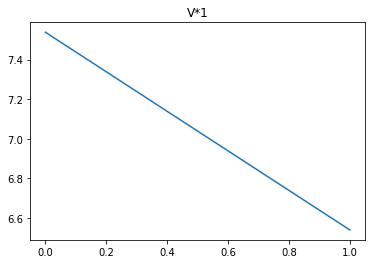

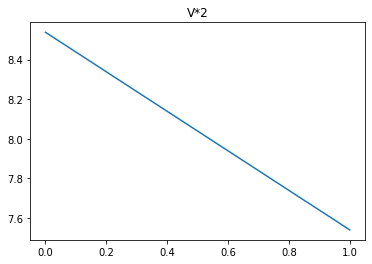

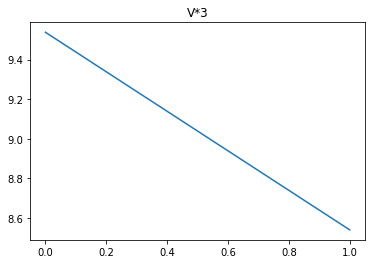

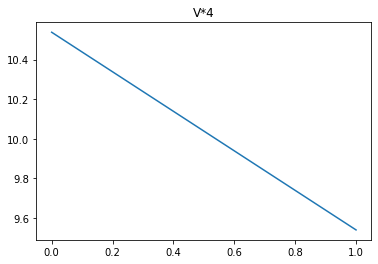

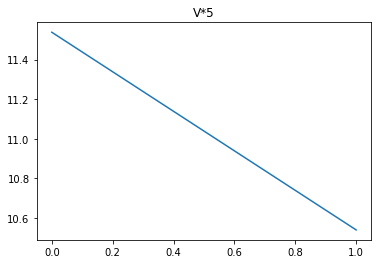

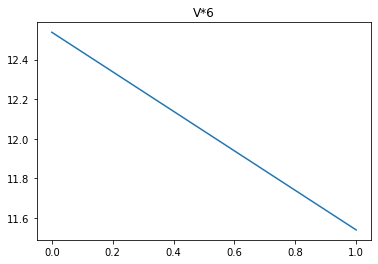

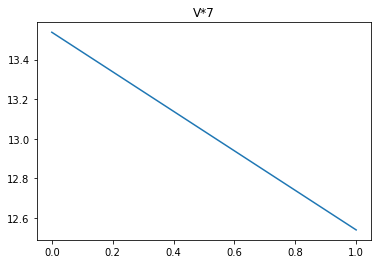

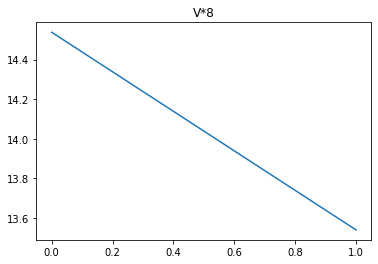

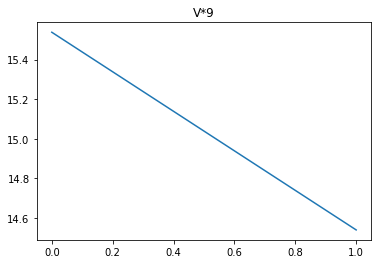

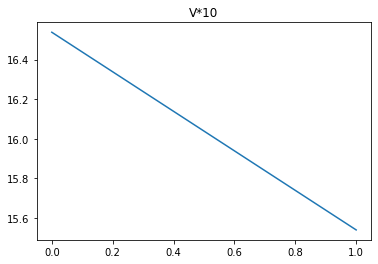

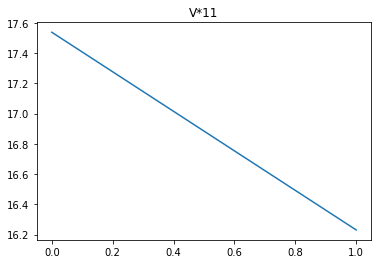

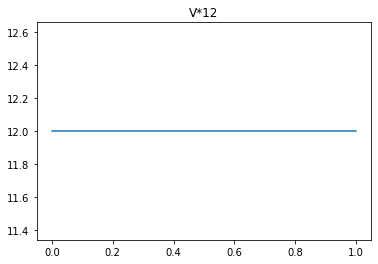

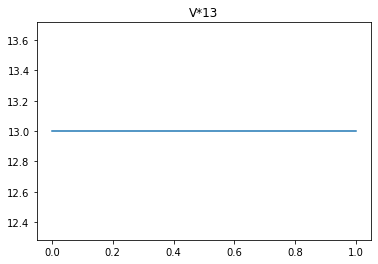

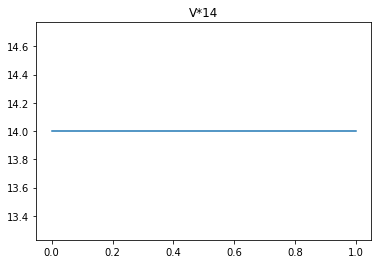

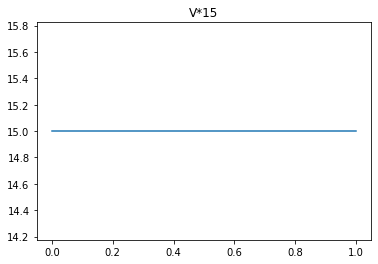

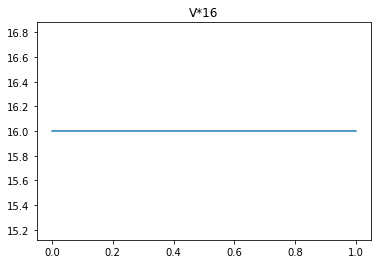

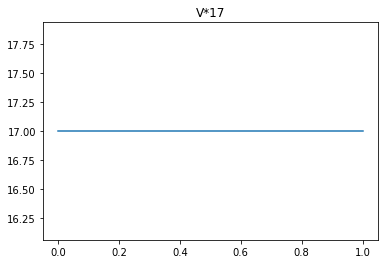

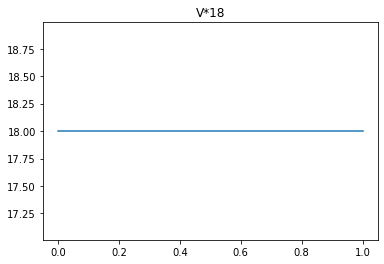

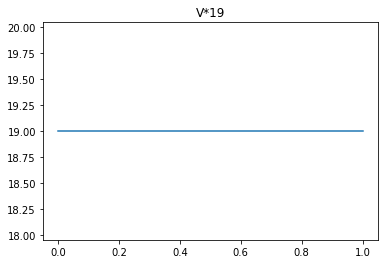

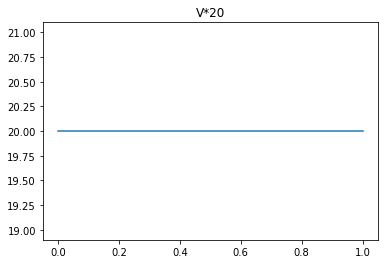

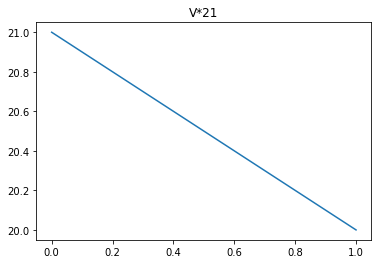

[ 5.53846154  6.53846154  7.53846154  8.53846154  9.53846154 10.53846154
 11.53846154 12.53846154 13.53846154 14.53846154 15.53846154 16.23076923
 12.         13.         14.         15.         16.         17.
 18.         19.         20.         20.        ]
policy 1 is 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
policy 2 is 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
V = np.zeros(22)
gamma = 1
V0 = []
V1 = []
V2 = []
V3 = []
V4 = []
V5 = []
V6 = []
V7 = []
V8 = []
V9 = []
V10 = []
V11 = []
V12 = []
V13 = []
V14 = []
V15 = []
V16 = []
V17 = []
V18 = []
V19 = []
V20 = []
V21 = []

policy1 = []
policy2 = []
x = 0
for i in range(2):

  living_reward = -i
  Vstar = value_iteration(V, living_reward , gamma)
  V0.append(Vstar[0])
  V1.append(Vstar[1])
  V2.append(Vstar[2])
  V3.append(Vstar[3])
  V4.append(Vstar[4])
  V5.append(Vstar[5])
  V6.append(Vstar[6])
  V7.append(Vstar[7])
  V8.append(Vstar[8])
  V9.append(Vstar[9])
  V10.append(Vstar[10])
  V11.append(Vstar[11])
  V12.append(Vstar[12])
  V13.append(Vstar[13])
  V14.append(Vstar[14])
  V15.append(Vstar[15])
  V16.append(Vstar[16])
  V17.append(Vstar[17])
  V18.append(Vstar[18])
  V19.append(Vstar[19])
  V20.append(Vstar[20])
  V21.append(Vstar[21])


  if x >0:
    policy2 = value_to_policy(Vstar, living_reward, gamma)
  else:
    policy1 = value_to_policy(Vstar, living_reward, gamma)
    x+=1

print(policy1)
print(policy2)
#plt.figure()

plot = plt.plot(V0)
plt.title('V*0')
#plt.legend(range(-5,5))
#plt.xticks(range(22))
plt.show(plot)

plot = plt.plot(V1)
plt.title('V*1')
plt.show(plot)

plot = plt.plot(V2)
plt.title('V*2')
plt.show(plot)

plot = plt.plot(V3)
plt.title('V*3')
plt.show(plot)

plot = plt.plot(V4)
plt.title('V*4')
plt.show(plot)

plot = plt.plot(V5)
plt.title('V*5')
plt.show(plot)

plot = plt.plot(V6)
plt.title('V*6')
plt.show(plot)

plot = plt.plot(V7)
plt.title('V*7')
plt.show(plot)

plot = plt.plot(V8)
plt.title('V*8')
plt.show(plot)

plot = plt.plot(V9)
plt.title('V*9')
plt.show(plot)

plot = plt.plot(V10)
plt.title('V*10')
plt.show(plot)

plot = plt.plot(V11)
plt.title('V*11')
plt.show(plot)

plot = plt.plot(V12)
plt.title('V*12')
plt.show(plot)

plot = plt.plot(V13)
plt.title('V*13')
plt.show(plot)

plot = plt.plot(V14)
plt.title('V*14')
plt.show(plot)

plot = plt.plot(V15)
plt.title('V*15')
plt.show(plot)

plot = plt.plot(V16)
plt.title('V*16')
plt.show(plot)

plot = plt.plot(V17)
plt.title('V*17')
plt.show(plot)

plot = plt.plot(V18)
plt.title('V*18')
plt.show(plot)

plot = plt.plot(V19)
plt.title('V*19')
plt.show(plot)

plot = plt.plot(V20)
plt.title('V*20')
plt.show(plot)

plot = plt.plot(V21)
plt.title('V*21')
plt.show(plot)

print(Vstar)
print('policy 1 is ')
print(policy1)
print('policy 2 is ')
print(policy2)
